# GAN (Generative Adversarial Networks)

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2025-01-05 10:07:36.685978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 10:07:36.686057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 10:07:36.687431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 10:07:36.694735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 10:07:37.524355: W tensorflow/compiler/tf2

2.15.0


In [2]:
!nvidia-smi


Sun Jan  5 10:07:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.01              Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8             10W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# import the data for the true values 

(train_images, _), (_,_) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 256 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



2025-01-05 10:13:49.935949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-05 10:13:50.160641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Generator 

Output formula:

$$ output = (input - 1) * stride - 2*padding + kernel + output padding$$

In [5]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    
    model.add(Reshape((7,7,256))) 
    
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh'))
    
    return model 

In [6]:
generator = make_generator_model()
generator.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 64)        2

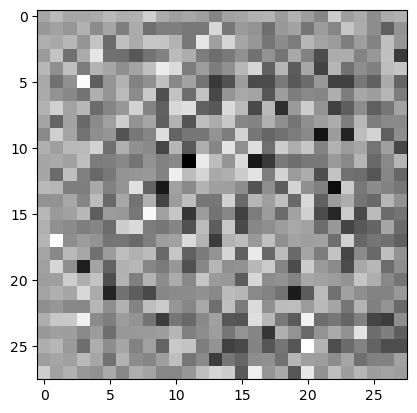

In [7]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator 

In [9]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

    

In [10]:
discriminator = make_discriminator_model() 
decision = discriminator(generated_image)
print(decision)

discriminator.summary()

tf.Tensor([[0.49983868]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    

## Loss function 

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
# Discriminator loss 

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

# Generator loss 

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
# optimizators 

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
@tf.function 

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generators = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generators, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        

In [19]:
import time 

grid_size_x: int = 10 
grid_size_y: int = 10 
seed = tf.random.normal([grid_size_x*grid_size_y, noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time() 
        
        for image_batch in dataset: 
            train_step(image_batch)
        
        generated_images(generator, seed)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    generated_images(generator, seed)

In [20]:
def generated_images(model, test_input):
    
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(grid_size_x,grid_size_y))
    for i in range(predictions.shape[0]):
      plt.subplot(grid_size_x, grid_size_y, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')            
    plt.show()
    

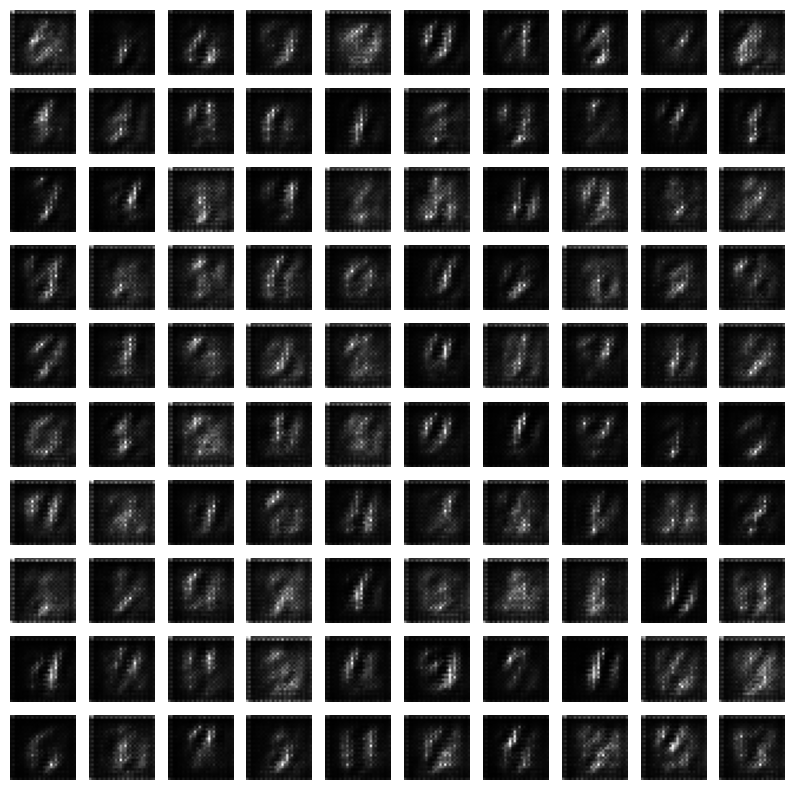

Time for epoch 1 is 154.0567181110382 sec


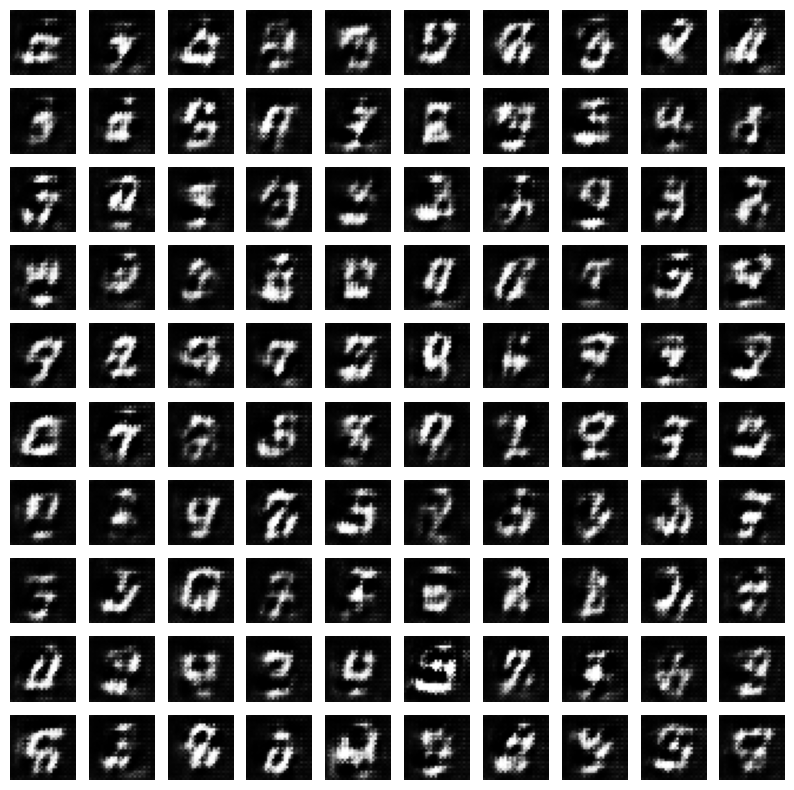

Time for epoch 2 is 153.28058862686157 sec


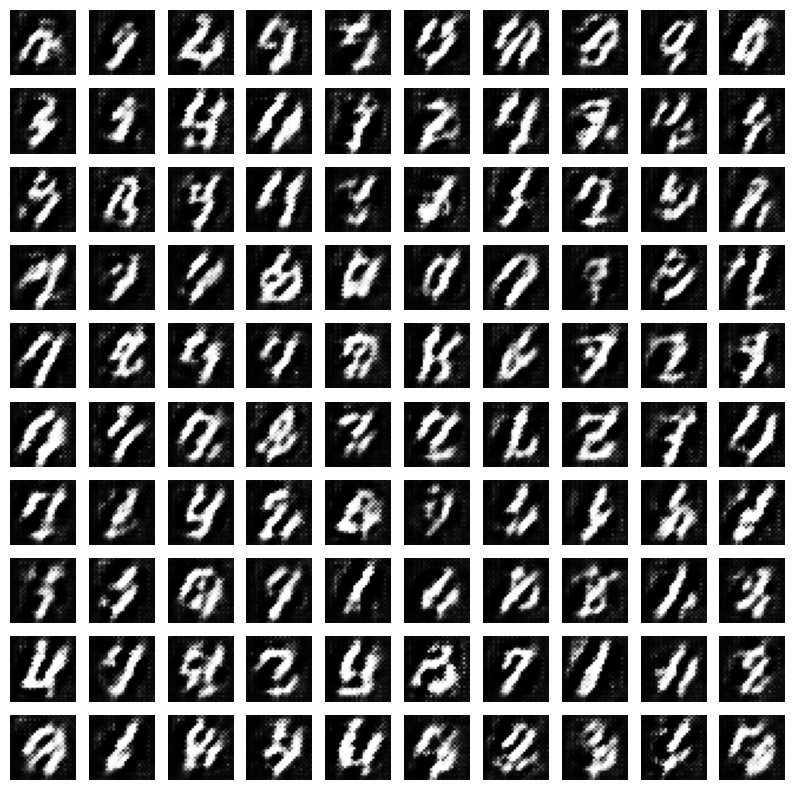

Time for epoch 3 is 155.14021849632263 sec


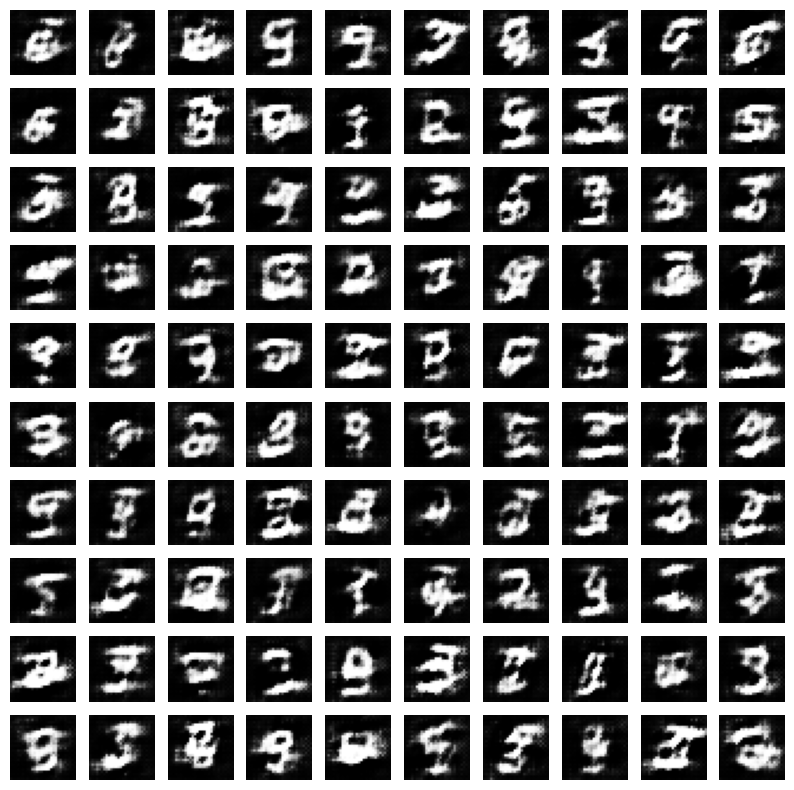

Time for epoch 4 is 153.49068880081177 sec


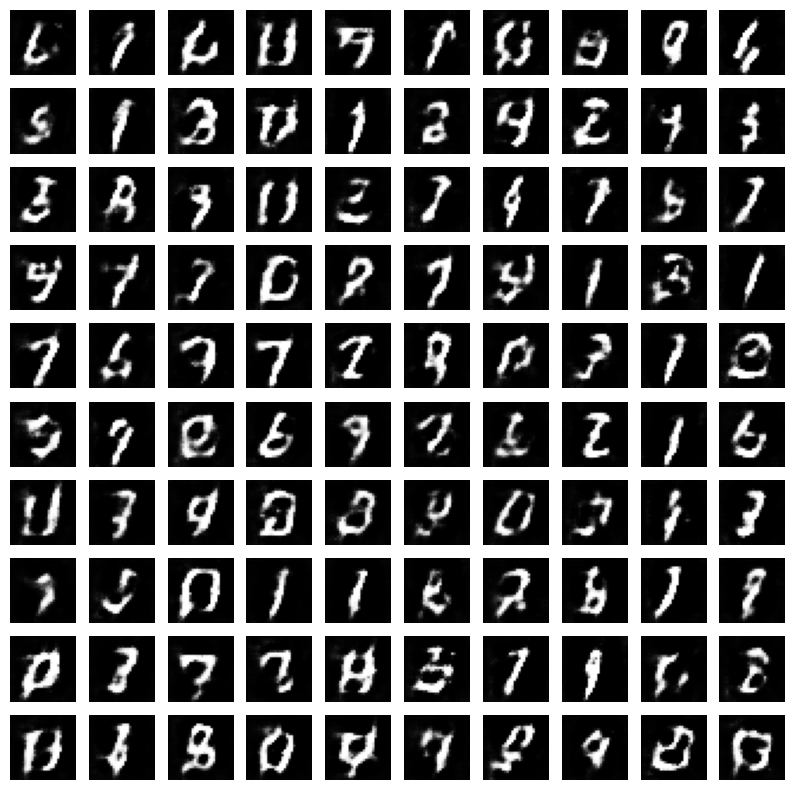

Time for epoch 5 is 184.54235529899597 sec


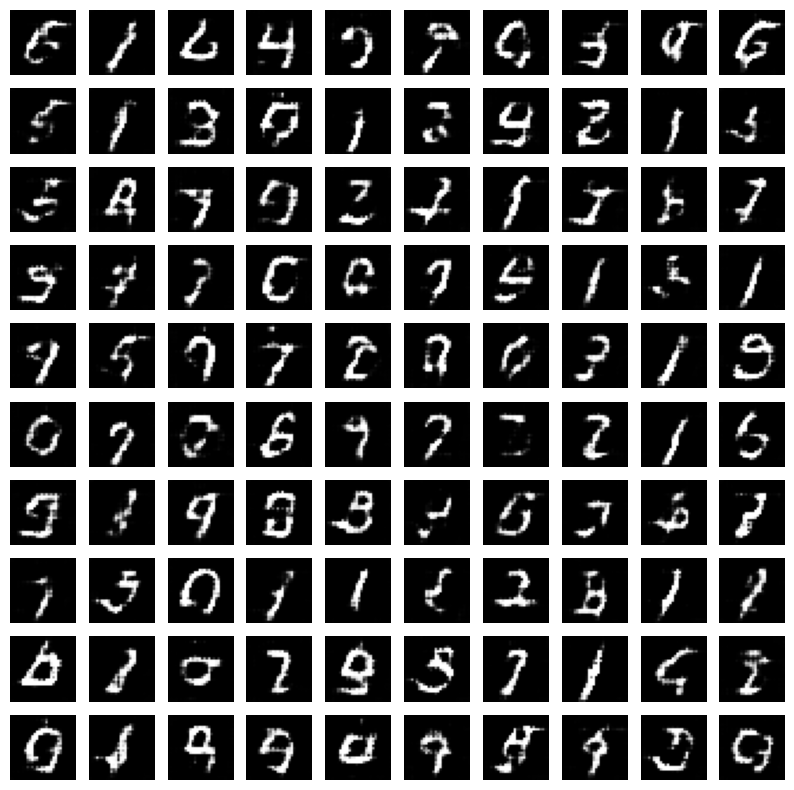

Time for epoch 6 is 197.39427590370178 sec


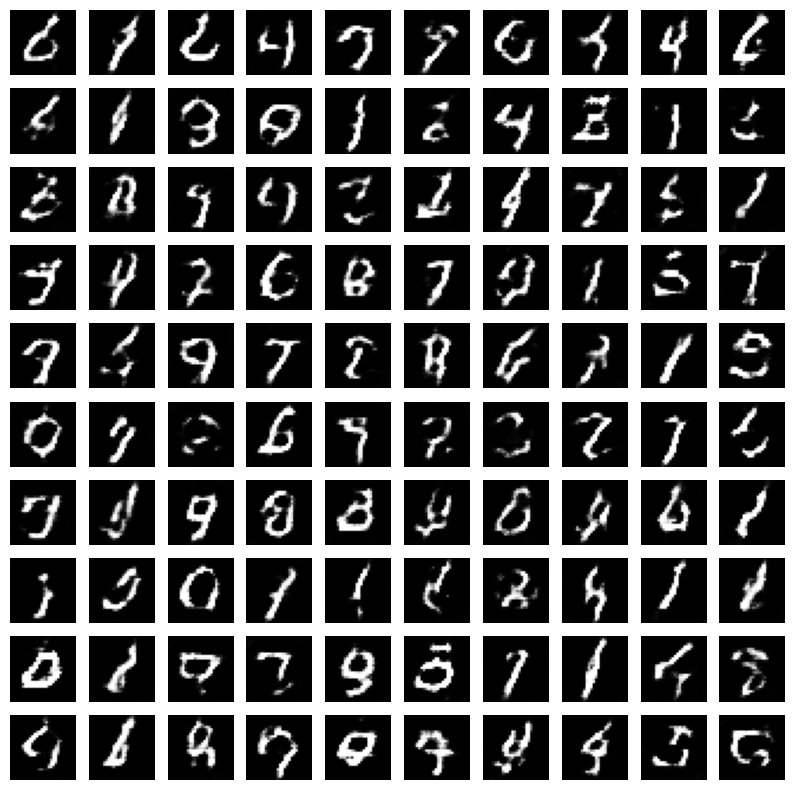

Time for epoch 7 is 191.55202794075012 sec


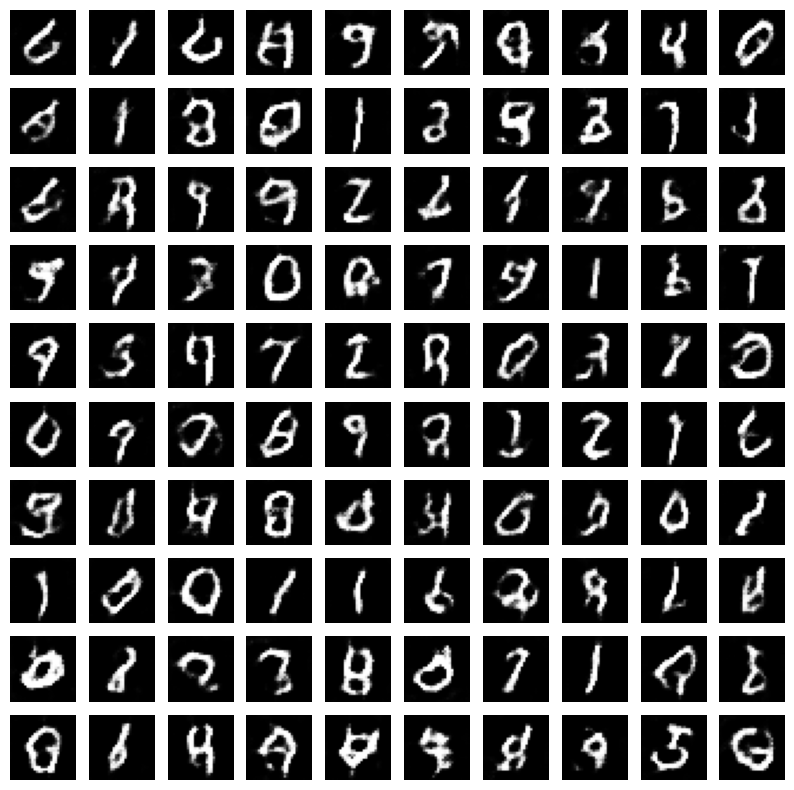

Time for epoch 8 is 201.85886454582214 sec


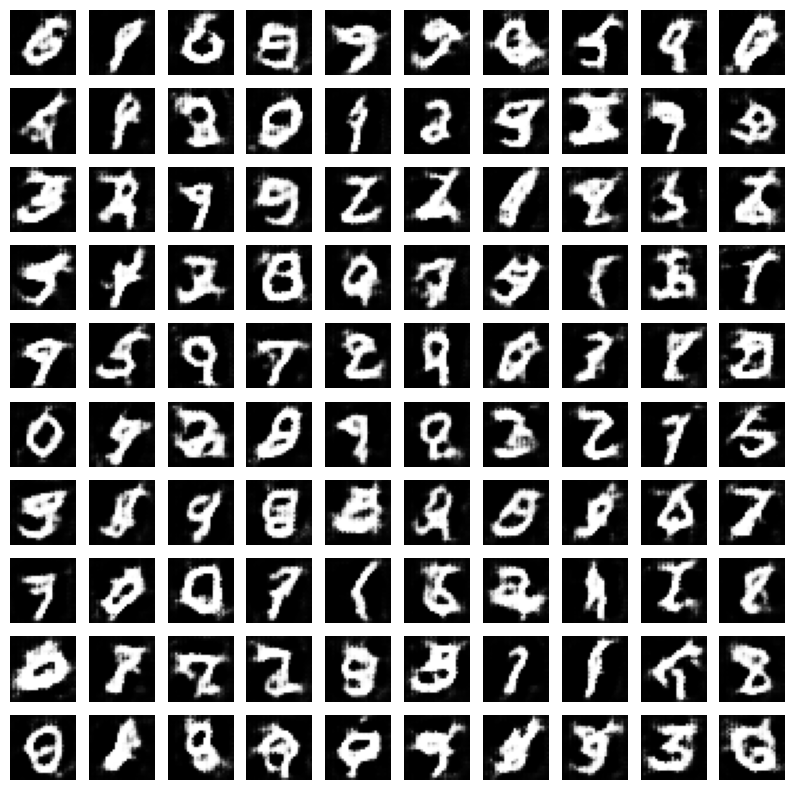

Time for epoch 9 is 204.771253824234 sec


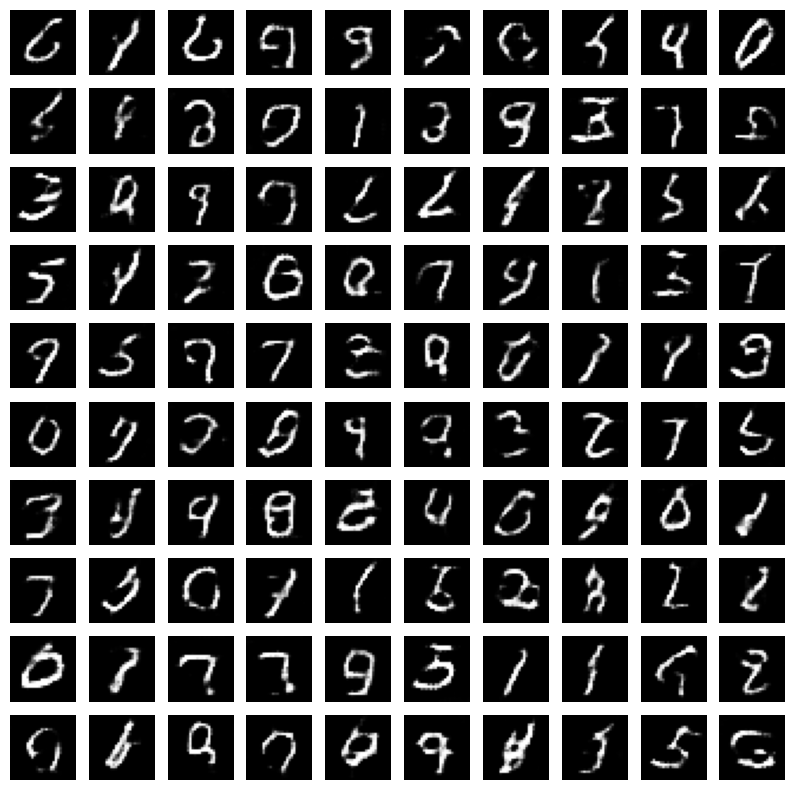

Time for epoch 10 is 200.18456506729126 sec


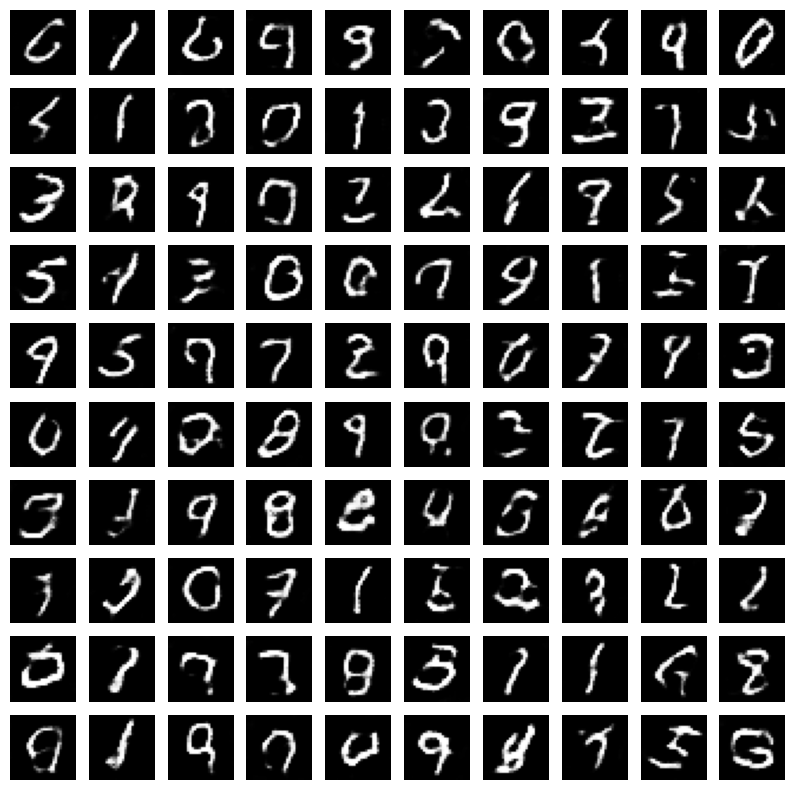

Time for epoch 11 is 191.2057204246521 sec


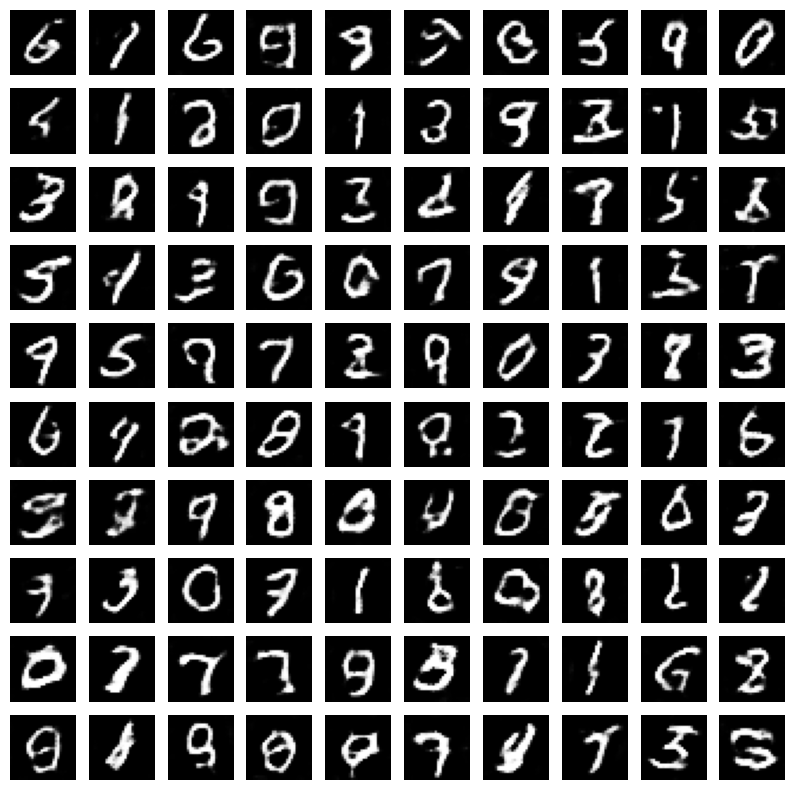

Time for epoch 12 is 183.28365421295166 sec


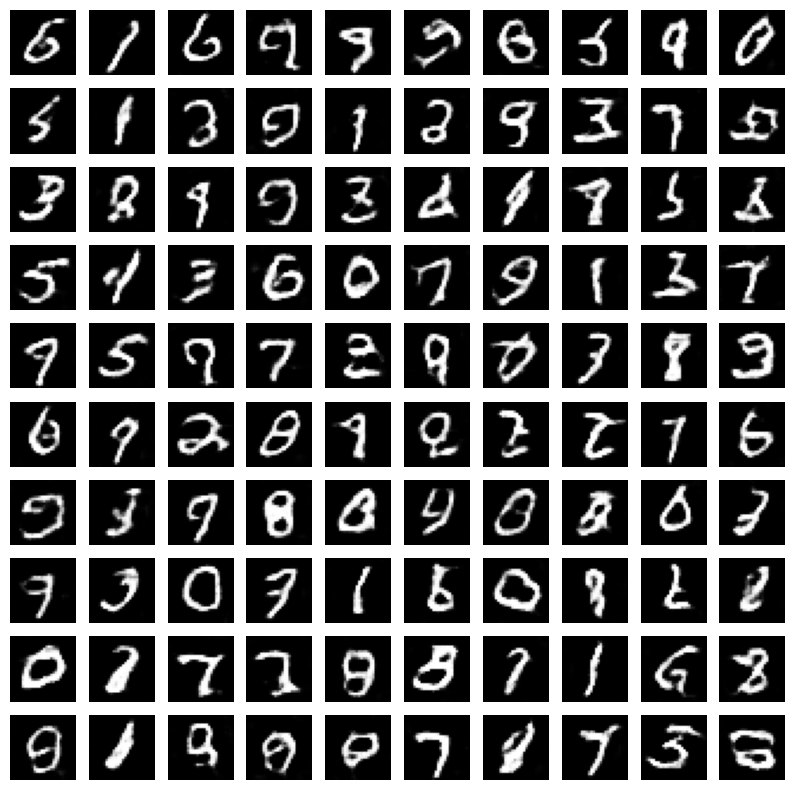

Time for epoch 13 is 188.85598254203796 sec


KeyboardInterrupt: 

In [21]:
## %%time
EPOCHS = 100
train(train_dataset, EPOCHS)